# ID5059 Group Project - Gradient Boosting Model for Temperature Prediction
##  This notebook implements a Gradient Boosting model to predict temperature (t2m) from weather data.


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Importing necessary librarie
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# For modeling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

## 2. Load Data

In [2]:
# Function to load data from file with sampling
def loadData(fileName, filePath="./", delimiter=",", sample_size=None, random_state=1):
    path = Path(filePath) / fileName
    if not path.is_file():
        raise Exception(f"File not found: {path}")
    
    if sample_size is not None:
        # Load only a sample of the data
        # First count total lines to determine skiprows
        total_rows = sum(1 for _ in open(path)) - 1  # Subtract 1 for header
        
        if sample_size >= total_rows:
            return pd.read_csv(path, sep=delimiter)
        
        # Generate random row indices to sample
        np.random.seed(random_state)
        skip_indices = sorted(np.random.choice(
            range(1, total_rows + 1), 
            size=total_rows - sample_size, 
            replace=False
        ))
        
        # Always include header (row 0)
        return pd.read_csv(path, sep=delimiter, skiprows=skip_indices)
    else:
        # Load the entire dataset
        return pd.read_csv(path, sep=delimiter)

# Function to convert datetime components
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = ((data["month"] % 12 + 3) // 3)  # Winter: 1, Spring: 2, Summer: 3, Fall: 4
    return data

# Function to prepare data (drop id, convert time, extract components)
def prepareData(data, keep_valid_time=False):
    # Make a copy to avoid modifying the original
    data = data.copy()
    
    # Drop ID column
    data.drop(["id"], axis=1, inplace=True)
    
    # Convert valid_time to datetime
    data["valid_time"] = pd.to_datetime(data["valid_time"])
    
    # Extract datetime components
    data = convertDateTimeToComponents(data, "valid_time")
    
    # Optionally keep valid_time (needed for test predictions)
    if not keep_valid_time:
        data.drop(["valid_time"], axis=1, inplace=True)
    
    return data

### 3.1 Preprocessing

In [3]:
# Load a sample of the training data
filePath = "./"
sample_size_train = 100000  # Number of rows to sample
dataTrain = loadData("train.csv", filePath, sample_size=sample_size_train, random_state=RANDOM_SEED)


# Load test data (no need to sample)
sample_size_test = 100000  # Number of rows to sample
dataTest = loadData("train.csv", filePath, sample_size=sample_size_test, random_state=RANDOM_SEED)

# Preprocess both datasets
dataTrain = prepareData(dataTrain)
dataTest = prepareData(dataTest, keep_valid_time=True)  # Keep valid_time for predictions

# Save valid_time from test data before dropping
test_valid_time = dataTest['valid_time'].copy()
if 'valid_time' in dataTest.columns:
    dataTest.drop(["valid_time"], axis=1, inplace=True)

# Display shapes after preprocessing
print(f"Training data shape: {dataTrain.shape}")
print(f"Test data shape: {dataTest.shape}")

Training data shape: (100000, 16)
Test data shape: (100000, 16)


In [24]:
# Define categorical and numerical attributes
attributes = list(dataTrain.columns)
one_hot_attributes = ["year", "month", "day", "hour", "season", "ptype"]
numerical_attributes = list(filter(lambda item: item not in one_hot_attributes + ["t2m"], attributes))

print("Categorical attributes for one-hot encoding:", one_hot_attributes)
print("Numerical attributes for scaling:", numerical_attributes)

# Prepare X and y for training data
X_train = dataTrain.drop("t2m", axis=1)
y_train = dataTrain["t2m"]

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED
)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Create preprocessing pipelines
onehot_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Combine into column transformer
preprocessor = ColumnTransformer(transformers=[
    ("cat-onehot", onehot_pipeline, one_hot_attributes),
    ("numerical", numerical_pipeline, numerical_attributes)
])

# Extract test subset for predictions
test_subset = dataTest[(dataTest['latitude'] == 56.25) & (dataTest['longitude'] == -2.75)]
print(f"Test subset shape for predictions: {test_subset.shape}")

# Now ready to proceed with model training
print("Preprocessing complete. Ready for model training.")

Categorical attributes for one-hot encoding: ['year', 'month', 'day', 'hour', 'season', 'ptype']
Numerical attributes for scaling: ['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc']
Training set shape: (80000, 15)
Validation set shape: (20000, 15)
Test subset shape for predictions: (70, 16)
Preprocessing complete. Ready for model training.


In [25]:
# Add this code before model training
def add_nearby_features(df):
    """Add spatial and temporal lag features to the dataframe"""
    # Make a copy to avoid modifying the original
    df_with_nearby = df.copy()
    
    # 1. Add spatial lag features (nearby locations)
    # Create a dictionary to store grid points by their coordinates
    grid_dict = {}
    for idx, row in df.iterrows():
        lat, lon = row['latitude'], row['longitude']
        if (lat, lon) not in grid_dict:
            grid_dict[(lat, lon)] = []
        grid_dict[(lat, lon)].append(idx)
    
    # For each location, find neighboring grid points (±0.25 degrees)
    nearby_cols = ['tp', 'sp', 'u10', 'v10', 'tcc']  # Features to create lags for
    lat_step, lon_step = 0.25, 0.25  # Standard grid step in the dataset
    
    # Initialize new columns with NaN
    for col in nearby_cols:
        for direction in ['north', 'south', 'east', 'west']:
            df_with_nearby[f'{col}_{direction}_lag'] = np.nan
    
    # Fill with actual values where available
    for (lat, lon), indices in grid_dict.items():
        # Find neighbors
        neighbors = {
            'north': grid_dict.get((lat + lat_step, lon), []),
            'south': grid_dict.get((lat - lat_step, lon), []),
            'east': grid_dict.get((lat, lon + lon_step), []),
            'west': grid_dict.get((lat, lon - lon_step), [])
        }
        
        # For each index at this location
        for idx in indices:
            # For each feature we want to create a lag for
            for col in nearby_cols:
                # For each direction
                for direction, neighbor_indices in neighbors.items():
                    if neighbor_indices:
                        # Take the mean of the neighboring values
                        df_with_nearby.loc[idx, f'{col}_{direction}_lag'] = df.loc[neighbor_indices, col].mean()
    
    # 2. Add temporal lag features (previous hours)
    # Sort by location and time
    df_sorted = df.sort_values(['latitude', 'longitude', 'year', 'month', 'day', 'hour'])
    
    # Add lag features for the previous hour at the same location
    for col in nearby_cols:
        df_with_nearby[f'{col}_prev_hour'] = df_sorted.groupby(['latitude', 'longitude'])[col].shift(1)
    
    # Fill NaN values with the current values (for first hour)
    for col in nearby_cols:
        df_with_nearby[f'{col}_prev_hour'].fillna(df_with_nearby[col], inplace=True)
    
    # Fill any remaining NaN values with column means
    df_with_nearby.fillna(df_with_nearby.mean(), inplace=True)
    
    return df_with_nearby

# Apply the function to add nearby features
X_train_with_nearby = add_nearby_features(X_train)
X_val_with_nearby = add_nearby_features(X_val)

C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_20348\337348227.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_with_nearby[f'{col}_prev_hour'].fillna(df_with_nearby[col], inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_20348\337348227.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

## 4. Model Training

### 4.1 Initial Gradient Boosting Model

In [28]:
# Define the model pipeline
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=200,      # Increase from 100
        learning_rate=0.05,    # Decrease for better generalization
        max_depth=5,           # Increase from 3 to capture non-linear patterns
        min_samples_split=5,   # Keep the same
        min_samples_leaf=2,    # Keep the same
        subsample=0.8,         # Add to reduce variance
        random_state=RANDOM_SEED
    ))
])

# Train the model
print("Training the initial Gradient Boosting model...")
gb_pipeline.fit(X_train_with_nearby, y_train)

Training the initial Gradient Boosting model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat-onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['year', 'month', 'day',
                                                   'hour', 'season', 'ptype']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'tp', 'u10', 'v10', 'sp',
                                                   'u100', 'v100', 'tcc'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           min_samples_leaf=2,
                                           min_samples_split=5,
                                           n_estimators=200, random_state=1,
                                           subsample=0.8))])

### 4.2 Model Evaluation

In [ ]:
# Make predictions
y_train_pred = gb_pipeline.predict(X_train_with_nearby)
y_val_pred = gb_pipeline.predict(X_val)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

Training RMSE: 1.8664
Validation RMSE: 1.9277
Training R²: 0.8539
Validation R²: 0.8486
Training MAE: 1.3744
Validation MAE: 1.4211


### 4.3 Visualization of Results

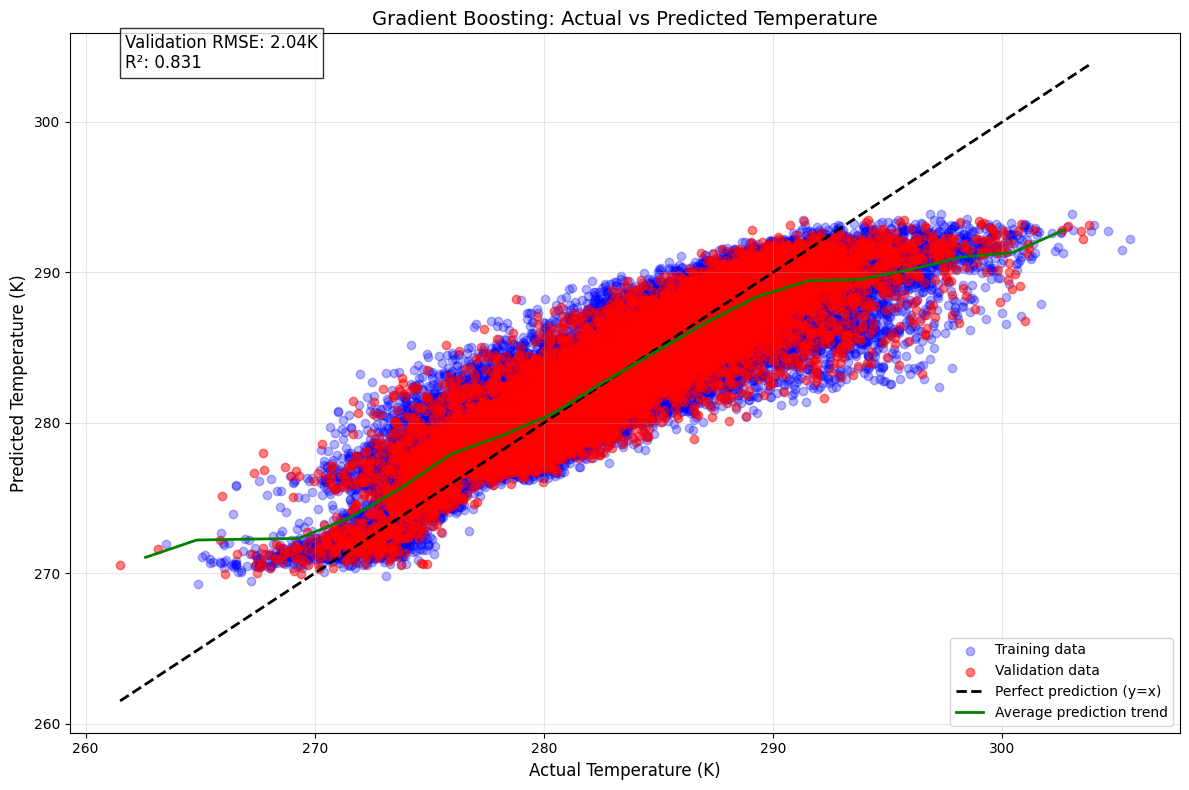

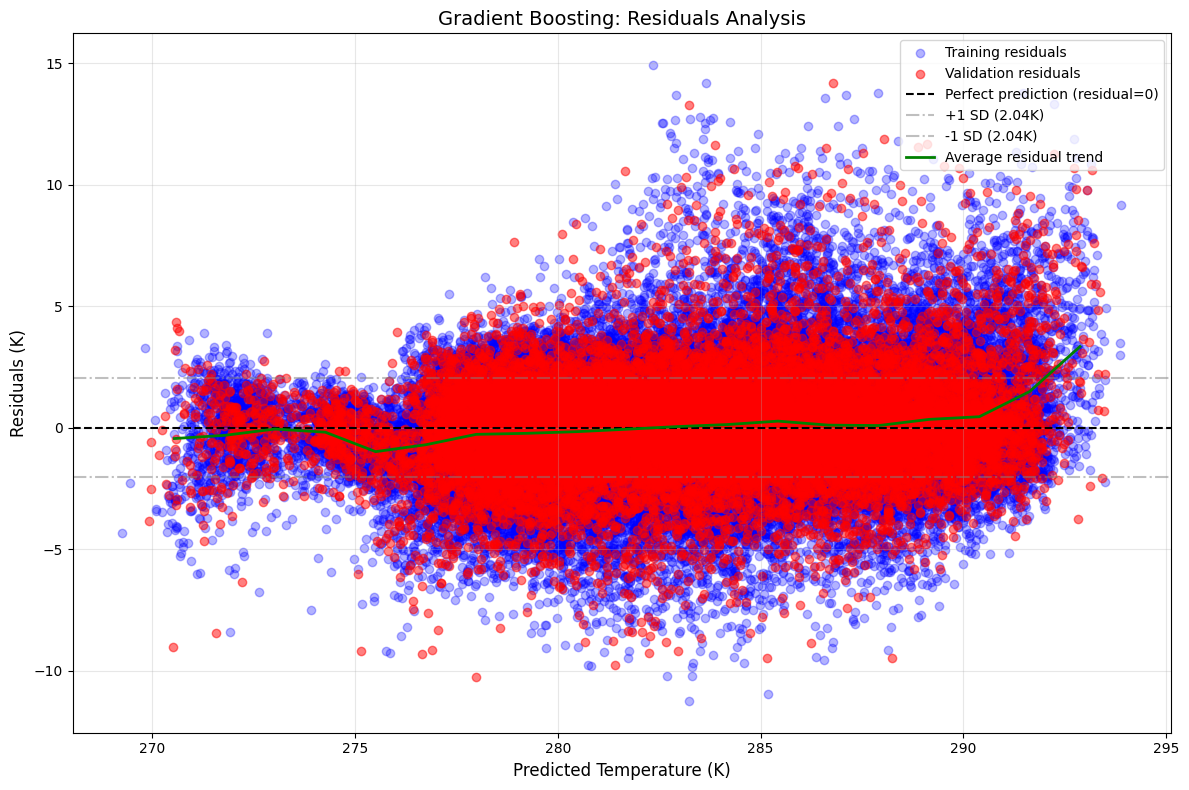

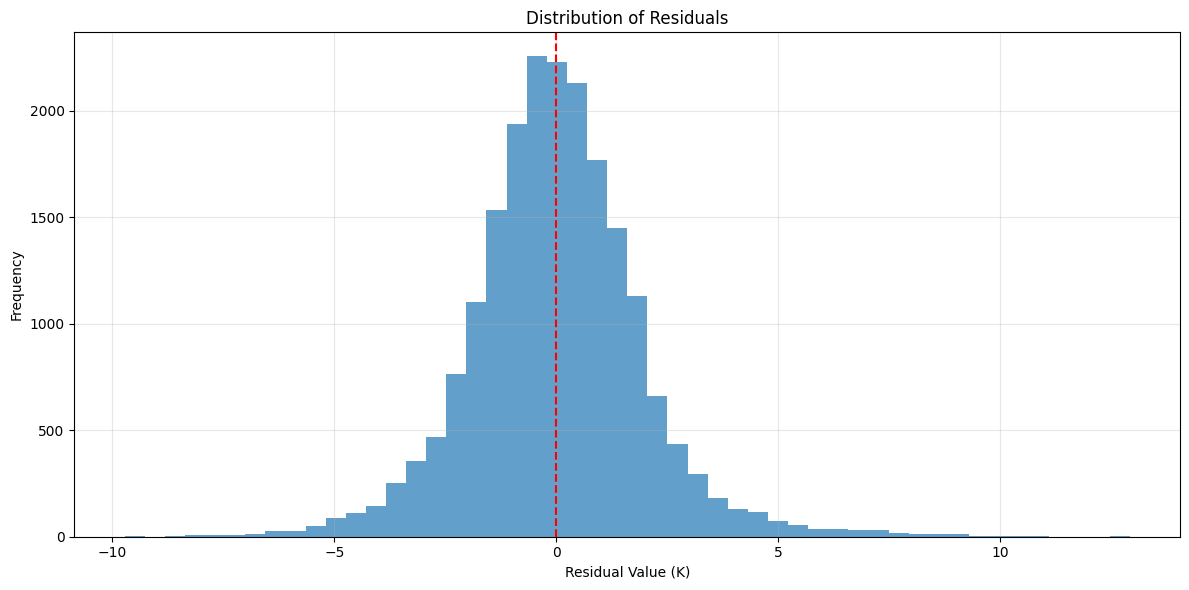

In [22]:
# 1. Improved Actual vs Predicted plot
plt.figure(figsize=(12, 8))

# Add separate colors for training and validation
plt.scatter(y_train, y_train_pred, alpha=0.3, label='Training data', color='blue')
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validation data', color='red')

# Add perfect prediction line with label
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'k--', lw=2, label='Perfect prediction (y=x)')

# Add a smoothed trend line to show actual model behavior
from scipy.stats import binned_statistic
bins = np.linspace(y_val.min(), y_val.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_val, y_val_pred, statistic='mean', bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average prediction trend')

# Add metrics to the plot
plt.text(0.05, 0.95, f"Validation RMSE: {val_rmse:.2f}K\nR²: {val_r2:.3f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('Actual Temperature (K)', fontsize=12)
plt.ylabel('Predicted Temperature (K)', fontsize=12)
plt.title('Gradient Boosting: Actual vs Predicted Temperature', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Improved Residuals Plot
plt.figure(figsize=(12, 8))

# Add separate colors for training and validation
plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.3, label='Training residuals', color='blue')
plt.scatter(y_val_pred, y_val - y_val_pred, alpha=0.5, label='Validation residuals', color='red')

# Add zero line
plt.axhline(y=0, color='k', linestyle='--', label='Perfect prediction (residual=0)')

# Add standard deviation bands
std_dev = np.std(y_val - y_val_pred)
plt.axhline(y=std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'+1 SD ({std_dev:.2f}K)')
plt.axhline(y=-std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'-1 SD ({std_dev:.2f}K)')

# Add a smoothed trend line for residuals
bins = np.linspace(y_val_pred.min(), y_val_pred.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_val_pred, y_val - y_val_pred, statistic='mean', bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average residual trend')

plt.xlabel('Predicted Temperature (K)', fontsize=12)
plt.ylabel('Residuals (K)', fontsize=12)
plt.title('Gradient Boosting: Residuals Analysis', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual Value (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Feature Importance